# Prepare Dataset for Model Training and Evaluating

# Amazon Customer Reviews Dataset

https://s3.amazonaws.com/dsoaws/amazon-reviews-pds/readme.html. 

## Note
This dataset has been taken down by AWS https://repost.aws/questions/QUnbXUqfmVRsOp54XNgphZGw/i-suddently-can-t-access-to-the-amazon-reviews-parquet-dataset-it-said-access-denied

## Schema

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [4]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## Download

Let's start by retrieving a subset of the Amazon Customer Reviews dataset. If the following link is down, download from here https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset?select=amazon_reviews_us_Digital_Software_v1_00.tsv

In [5]:
# !aws s3 cp 's3://dsoaws/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

In [8]:
import csv

# df = pd.read_csv(
#     "./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
#     delimiter="\t",
#     quoting=csv.QUOTE_NONE,
#     compression="gzip",
# )

df = pd.read_csv(
    "./data/amazon_reviews_us_Digital_Software_v1_00.tsv.zip",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="zip",
)
df.shape

(102084, 15)

In [9]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


Text(0, 0.5, 'Review Count')

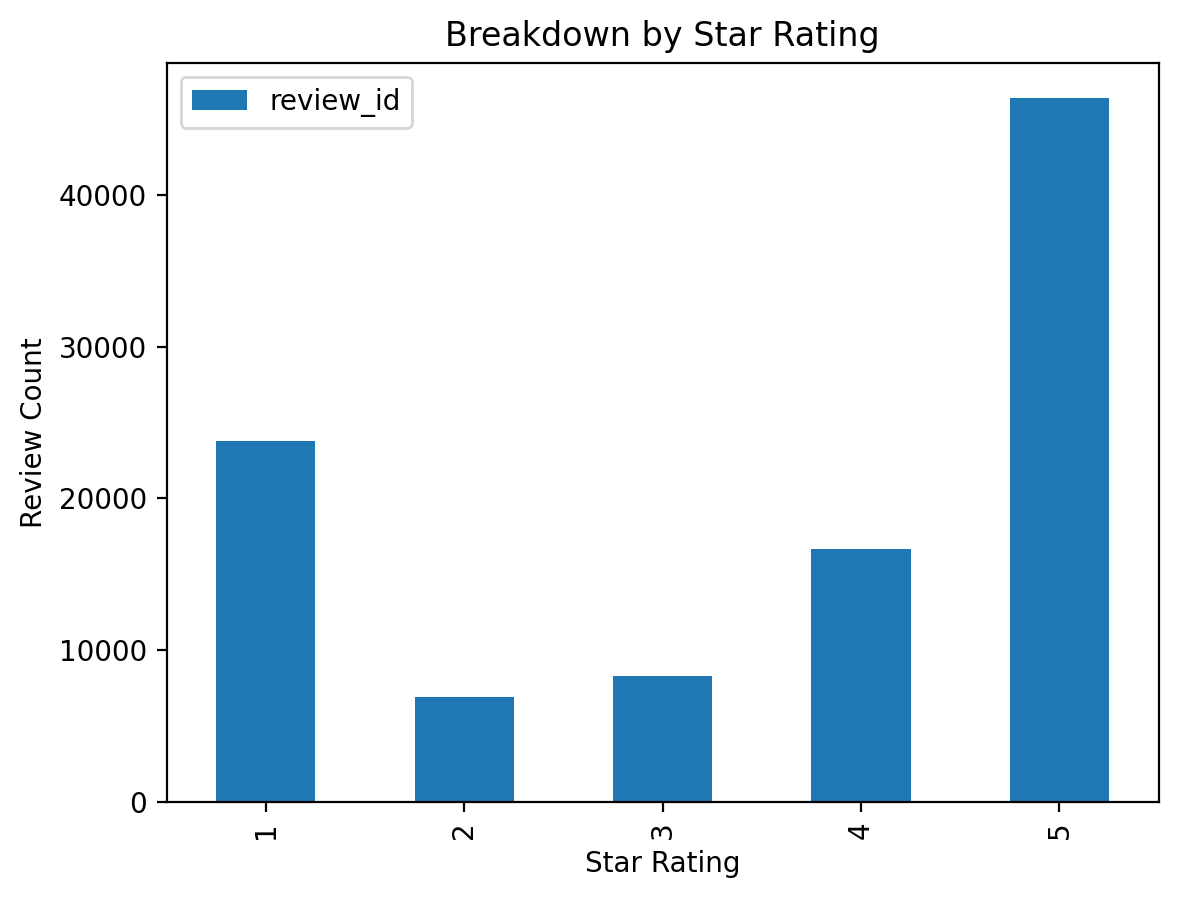

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

df[["star_rating", "review_id"]].groupby("star_rating").count().plot(kind="bar", title="Breakdown by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

# Balance the Dataset

In [11]:
print("Shape of dataframe before splitting {}".format(df.shape))

Shape of dataframe before splitting (102084, 15)


In [12]:
# Balance the dataset down to the minority class
df_grouped_by = df.groupby(["star_rating"]) 
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

Shape of balanced dataframe (34450, 15)


Text(0, 0.5, 'Review Count')

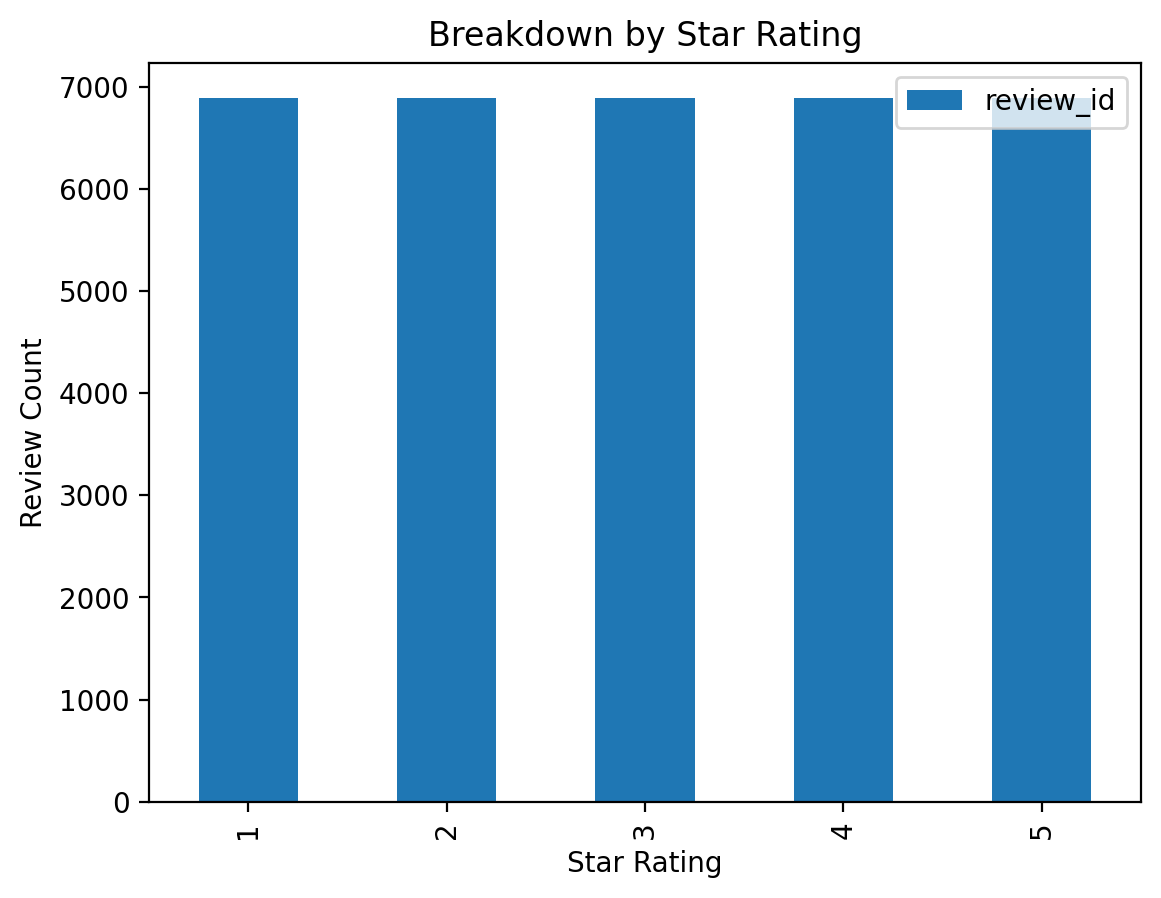

In [13]:
df_balanced[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="Breakdown by Star Rating"
)
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

In [14]:
df_balanced.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,21208501,RAJUOEKB5Y0I6,B00M9GTEPA,521201578,Intuit Quicken Home & Business 2015,Digital_Software,1,5,5,N,N,I upgraded from 2013 Quicken. I should have li...,I upgraded from 2013 Quicken. I should have li...,2015-02-16
1,US,44202567,R3ROJB7Z0WTVLY,B00FFINOWS,875090538,"TurboTax Deluxe Fed, Efile and State 2013",Digital_Software,1,0,0,N,Y,One Star,They have become to greedy on their price.,2015-05-31
2,US,52164833,R12RZUGT7WTDJ6,B009H7HHVW,390581397,MAGIX Video easy 4 HD [Download],Digital_Software,1,0,3,N,N,PS3 Issue,I downloaded the trial version of Video Easy 4...,2013-02-06
3,US,53007519,R36NS0QRVQEK6M,B0068TJE4A,429607071,H&R Block At Home Premium + State,Digital_Software,1,1,1,N,Y,Buyer Beware,I was a long time user of the Turbo-Tax softwa...,2012-03-18
4,US,53039634,R1RYEYHVEN6NT8,B00TKTWA32,437803962,Amazon Drive Desktop [Mac],Digital_Software,1,0,0,N,N,One Star,Doesn't work and won't connect. Fail.,2015-03-28


## Reduce dataset size
This part has been added to make the later notebooks faster

In [15]:
df_balanced.shape

(34450, 15)

In [16]:
df_balanced = df_balanced.sample(n=1000, replace=False, random_state=2024)

# Split the Data into Train, Validation, and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced["star_rating"])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout["star_rating"])

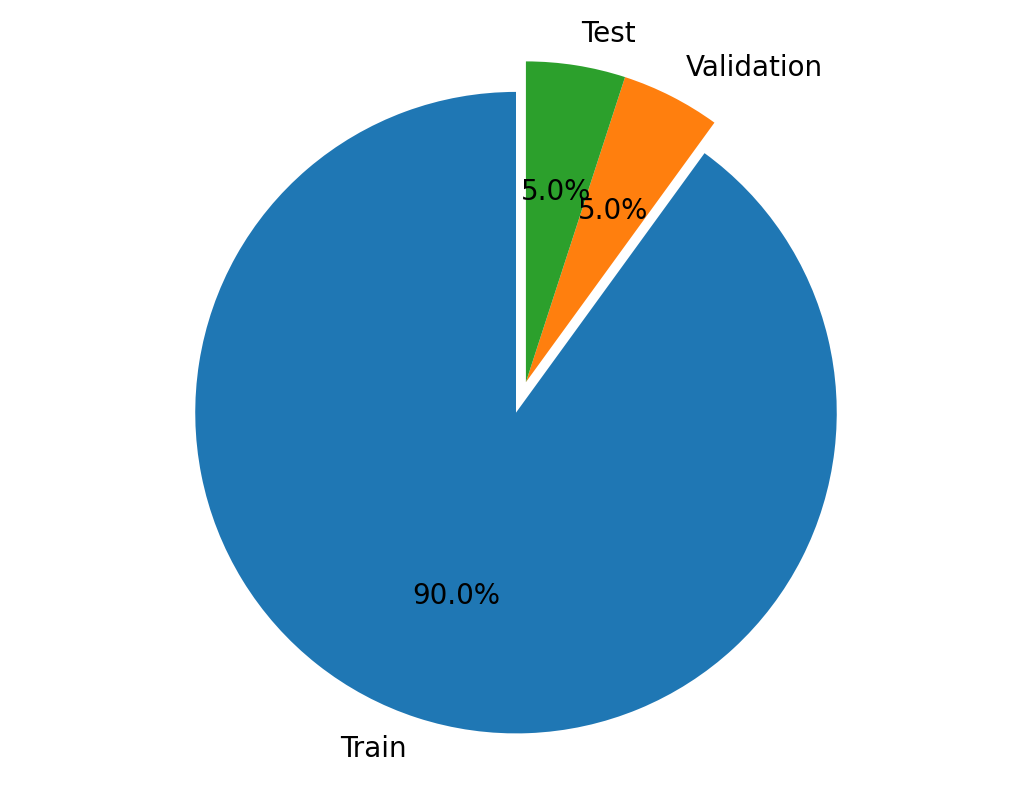

In [18]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

# Show 90% Train Data Split

In [19]:
df_train.shape

(900, 15)

<Axes: title={'center': '90% Train Breakdown by Star Rating'}, xlabel='star_rating'>

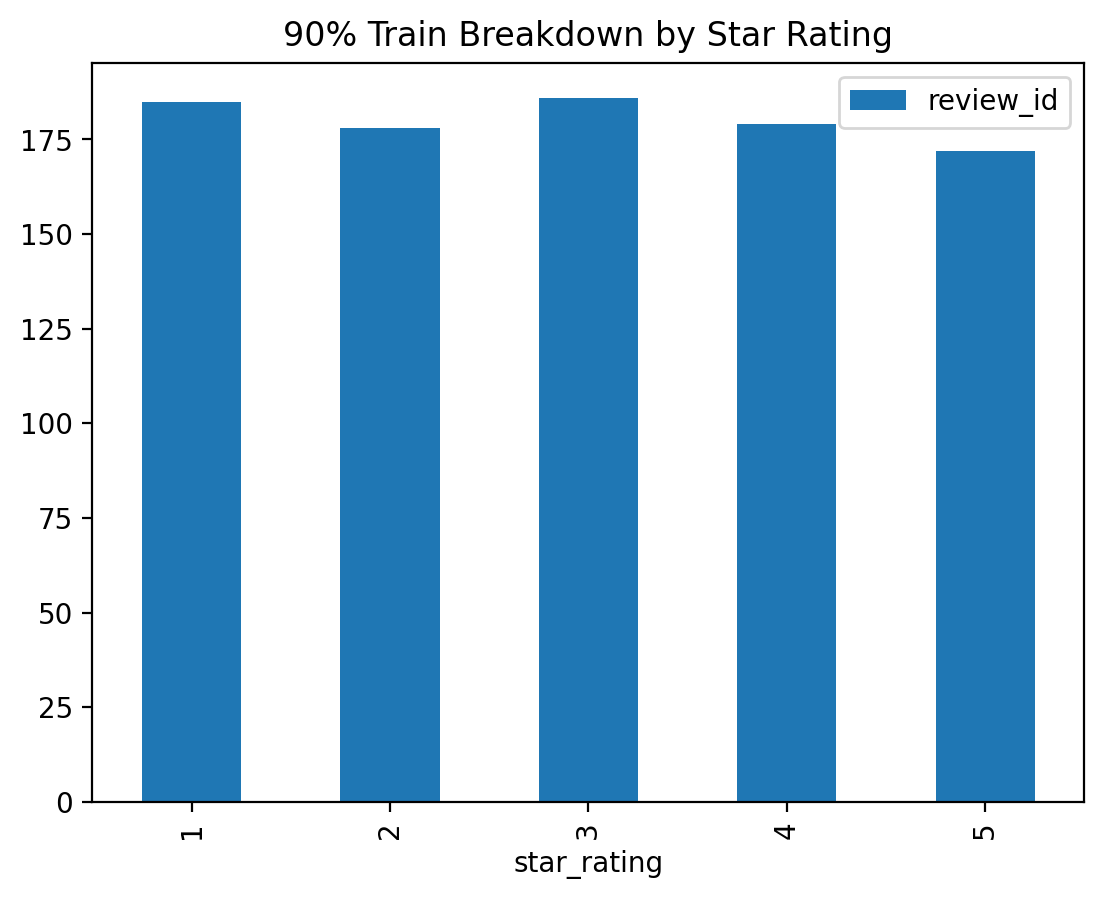

In [20]:
df_train[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="90% Train Breakdown by Star Rating"
)

# Show 5% Validation Data Split

In [21]:
df_validation.shape

(50, 15)

<Axes: title={'center': '5% Validation Breakdown by Star Rating'}, xlabel='star_rating'>

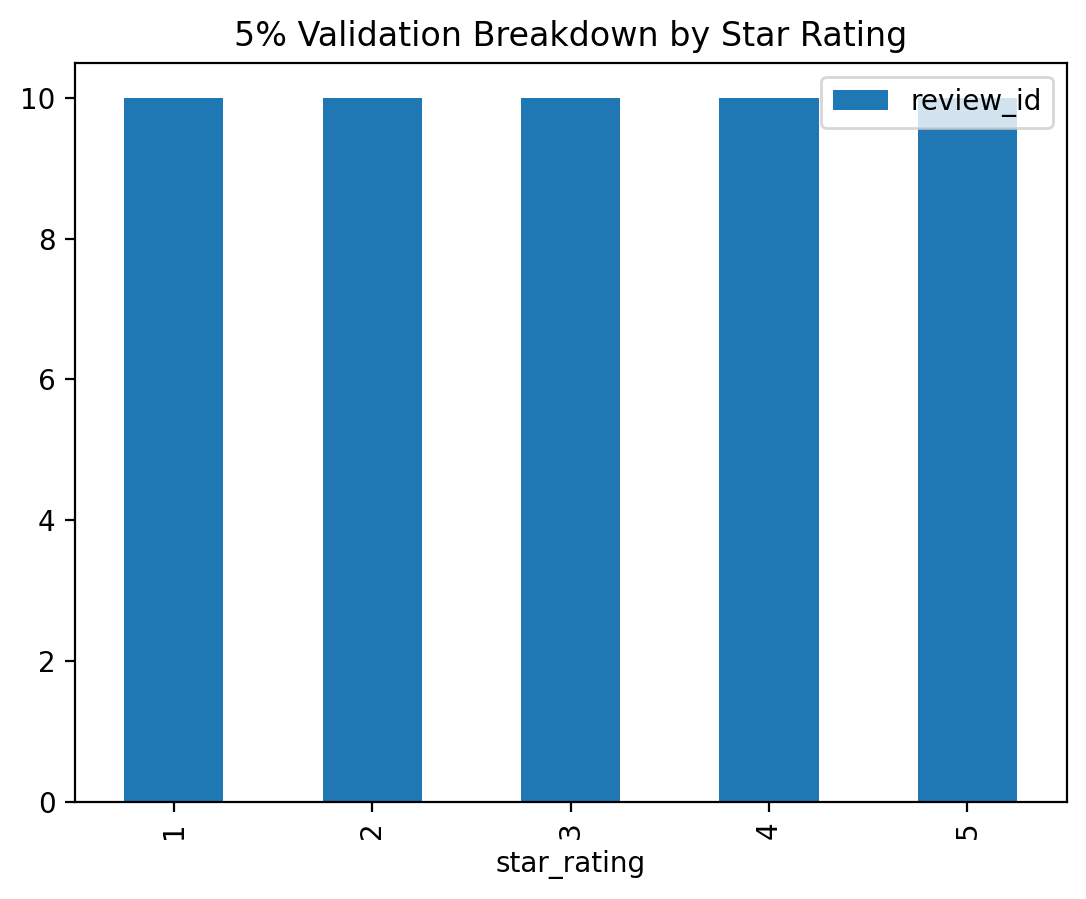

In [22]:
df_validation[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Validation Breakdown by Star Rating"
)

# Show 5% Test Data Split

In [23]:
df_test.shape

(50, 15)

<Axes: title={'center': '5% Test Breakdown by Star Rating'}, xlabel='star_rating'>

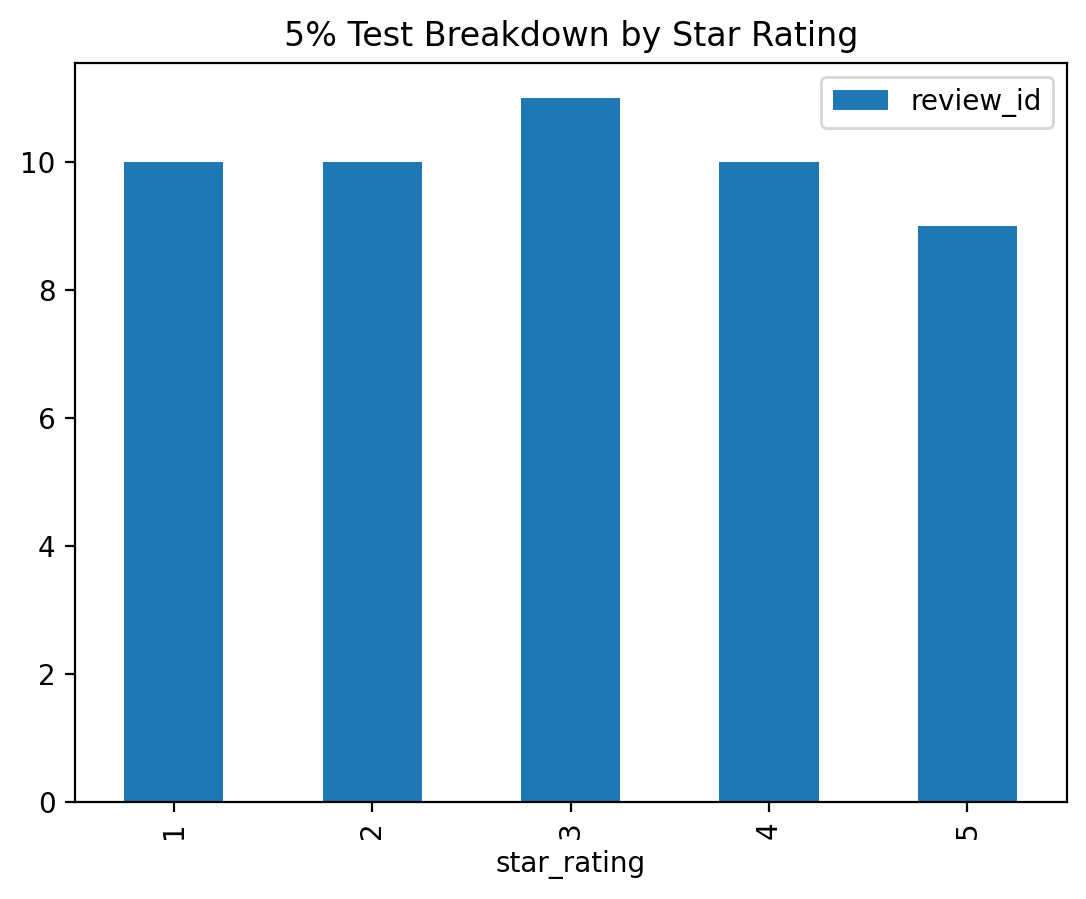

In [24]:
df_test[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Test Breakdown by Star Rating"
)

# Select `star_rating` and `review_body` for Training

In [25]:
df_train = df_train[["star_rating", "review_body"]]
df_train.shape

(900, 2)

In [26]:
df_train.head(5)

,star_rating,review_body
25715,4,This was suggested by two of my computer wizar...
21297,4,I only use this product for very basic editing...
24325,4,This software makes filing taxes much easier a...
33418,5,"Well detailed, easy to complete. Satisfied wit..."
8456,2,I have Quicken Deluxe 2013 & I could track pay...


# Write a CSV With No Header for Comprehend 

In [27]:
comprehend_train_path = "./amazon_reviews_us_Digital_Software_v1_00_comprehend.csv"
df_train.to_csv(comprehend_train_path, index=False, header=False)

# Upload Train Data to S3 for Comprehend

In [28]:
train_s3_prefix = "data"
comprehend_train_s3_uri = sess.upload_data(path=comprehend_train_path, key_prefix=train_s3_prefix)
comprehend_train_s3_uri

's3://sagemaker-us-east-1-276004173387/data/amazon_reviews_us_Digital_Software_v1_00_comprehend.csv'

In [29]:
!aws s3 ls $comprehend_train_s3_uri

2024-09-16 20:32:14     399635 amazon_reviews_us_Digital_Software_v1_00_comprehend.csv


# Store the location of our train data in our notebook server to be used next

In [30]:
%store comprehend_train_s3_uri

Stored 'comprehend_train_s3_uri' (str)


In [31]:
%store

Stored variables and their in-db values:
comprehend_train_s3_uri               -> 's3://sagemaker-us-east-1-276004173387/data/amazon
forecast_project_name                 -> 'util_power_forecast'
setup_dependencies_passed             -> True
setup_s3_bucket_passed                -> True


# Release Resources

In [32]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [33]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>